# Notebook 3c: CHM Relevance Assessment & Feature Engineering

**Autor:** Silas Pignotti  
**Datum:** Januar 2026  
**Version:** 1.0

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook performs **comprehensive CHM (Canopy Height Model) evaluation** to determine which structural features should be retained for model training. The analysis addresses three critical questions:

1. **Discriminative Power:** Do CHM features help distinguish tree genera **within** a city?
2. **Transfer Risk:** Do CHM features generalize **across** cities, or do they encode city-specific patterns?
3. **Feature Quality:** Are resampled CHM features (10m) contaminated by neighbors, or do they provide complementary information?

**Key Decision:** Based on quantitative evidence (η², Cohen's d, correlations), determine which CHM features to KEEP / EXCLUDE for subsequent modeling steps.

**Input:** Clean datasets from 03b_nan_handling_plausibility.ipynb  
**Output:** Feature decisions + city-invariant engineered features (height_m_norm, height_percentile)

### 1.2 Workflow

```
[PHASE 1: WITHIN-CITY DISCRIMINATIVE POWER]
├── Step 1.1: ANOVA F-Test (all CHM features)
├── Step 1.2: Effect Size (η²) Calculation
├── Step 1.3: Classification (weak/medium/strong)
└── Step 1.4: Visualization (Boxplots per Genus)

↓

[PHASE 2: CROSS-CITY TRANSFER RISK]
├── Step 2.1: Height Distribution Stats (per Genus & City)
├── Step 2.2: Cohen's d Calculation (Berlin/Hamburg → Rostock)
├── Step 2.3: Risk Classification (low/moderate/high)
└── Step 2.4: Visualization (Violin Plots, Cohen's d Barplot)

↓

[PHASE 3: FEATURE QUALITY ASSESSMENT]
├── Step 3.1: CHM Inter-Correlation (height_m ↔ CHM_resampled)
├── Step 3.2: CHM-Spectral Correlation (height_m ↔ NIR/NDVI)
├── Step 3.3: Edge-Filter Impact (η² comparison)
└── Step 3.4: Neighbor Contamination Diagnosis

↓

[PHASE 4: CITY-INVARIANT FEATURE ENGINEERING]
├── Step 4.1: Z-Score Normalization (per City & Genus)
├── Step 4.2: Percentile Rank (per City & Genus)
├── Step 4.3: Optional Ratio Features (if r ≥ 0.5)
└── Step 4.4: Validation (correlation with original)

↓

[PHASE 5: DECISION LOGIC & EXPORT]
├── Step 5.1: Automated Feature Classification (KEEP/EXCLUDE)
├── Step 5.2: Generate Rationale & Documentation
├── Step 5.3: Export Datasets with Engineered Features
└── Step 5.4: Export Metadata & Reports

↓

[OUTPUT]
├── trees_clean_chm_final_no_edge.gpkg
├── trees_clean_chm_final_20m_edge.gpkg
├── chm_relevance_analysis.csv
├── cross_city_height_analysis.json
├── chm_feature_decisions.json
└── chm_assessment_report.md
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `trees_clean_chm_final_*.gpkg` | GeoPackage | Datasets with KEEP CHM features only (EXCLUDE removed) |
| `chm_relevance_analysis.csv` | CSV | F-values, p-values, η², decisions per feature |
| `cross_city_height_analysis.json` | JSON | Distribution stats + Cohen's d per genus |
| `chm_correlation_analysis.json` | JSON | Correlation matrices (CHM ↔ CHM, CHM ↔ Spectral) |
| `chm_feature_decisions.json` | JSON | Final KEEP/EXCLUDE decisions + rationale |
| `chm_assessment_report.md` | Markdown | Comprehensive documentation with decision tree |

### 1.4 Theoretical Background

#### **Effect Size (η² - Eta-Squared)**

Quantifies the proportion of variance in height explained by genus membership.

$$\eta^2 = \frac{SS_{between}}{SS_{total}}$$

**Interpretation (Cohen's Guidelines):**
- **η² < 0.01:** Weak effect (genus explains <1% of height variance)
- **0.01 ≤ η² < 0.06:** Medium effect
- **η² ≥ 0.06:** Strong effect (genus is important predictor)

#### **Cohen's d (Effect Size for Group Differences)**

Measures standardized difference between two city distributions.

$$d = \frac{\bar{x}_1 - \bar{x}_2}{s_{pooled}}$$

where $s_{pooled} = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1 + n_2 - 2}}$

**Transfer Risk Classification:**
- **d < 0.5:** Low risk (distributions overlap ≥ 67%)
- **0.5 ≤ d < 0.8:** Moderate risk
- **d ≥ 0.8:** High risk (systematic city-specific offset)

#### **Neighbor Contamination Hypothesis**

10m CHM resampling in urban areas risks averaging **multiple objects**:
- Target tree crown
- Neighbor trees
- Buildings, street lamps

**Diagnostic:** Low correlation r(height_m, CHM_mean) < 0.7 indicates contamination  
**Expected if clean:** r > 0.85 (resampled should approximate 1m resolution)

---

## 2. SETUP & IMPORTS

In [24]:
# Core packages
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import warnings
from datetime import datetime
import gc

# Statistical analysis
from scipy import stats
from scipy.stats import f_oneway

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


In [25]:
# Google Colab: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Path Configuration

In [26]:
# Base paths
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / 'data'

# Input: Clean datasets (from 02_nan_handling)
# Note: These will be copied to local runtime for speed
DRIVE_INPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '02_nan_handling' / 'data'

# Output: CHM assessment results (03_chm_assessment)
BASE_OUTPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '03_chm_assessment'
OUTPUT_DATA_DIR = BASE_OUTPUT_DIR / 'data'
OUTPUT_METADATA_DIR = BASE_OUTPUT_DIR / 'metadata'
OUTPUT_FIGURES_DIR = BASE_OUTPUT_DIR / 'plots'

# Local runtime paths (for faster IO)
LOCAL_INPUT_DIR = Path('/content/data/input')

# Create directories in Drive (for outputs)
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_METADATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Create local directory
LOCAL_INPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Paths configured")
print(f"  Drive Input:  {DRIVE_INPUT_DIR}")
print(f"  Drive Output: {BASE_OUTPUT_DIR}")
print(f"  Local Input:  {LOCAL_INPUT_DIR}")

✓ Paths configured
  Drive Input:  /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/02_nan_handling/data
  Drive Output: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/03_chm_assessment
  Local Input:  /content/data/input


### 2.2 Visualization Setup

In [27]:
# Publication-ready style
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (14, 8),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    plt.rcParams['font.size'] = 11
    print("✓ Publication style configured")

setup_publication_style()

✓ Publication style configured


### 2.3 Statistical Utility Functions

In [28]:
def calculate_eta_squared(groups):
    """
    Calculate eta-squared (η²) effect size from grouped data.

    Args:
        groups: List of arrays (one per group/genus)

    Returns:
        float: η² value (0-1)
    """
    # Grand mean
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)

    # Total sum of squares
    ss_total = np.sum((all_data - grand_mean) ** 2)

    # Between-group sum of squares
    ss_between = sum(
        len(group) * (np.mean(group) - grand_mean) ** 2
        for group in groups
    )

    # Eta-squared
    eta2 = ss_between / ss_total if ss_total > 0 else 0

    return eta2


def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size between two groups.

    Args:
        group1, group2: Arrays of values

    Returns:
        float: Cohen's d value
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0

    return abs(d)  # Return absolute value (interested in magnitude)


def classify_effect_size_eta2(eta2):
    """Classify η² according to Cohen's guidelines."""
    if eta2 < 0.01:
        return 'weak'
    elif eta2 < 0.06:
        return 'medium'
    else:
        return 'strong'


def classify_transfer_risk(cohens_d_value):
    """Classify transfer risk based on Cohen's d."""
    if cohens_d_value < 0.5:
        return 'low'
    elif cohens_d_value < 0.8:
        return 'moderate'
    else:
        return 'high'


print("✓ Statistical utility functions defined")

✓ Statistical utility functions defined


### 2.4 CHM Feature Configuration

In [29]:
# CHM Features to analyze
CHM_FEATURES = ['height_m', 'CHM_mean', 'CHM_max', 'CHM_std']

# Thresholds for decision-making
ETA2_STRONG_THRESHOLD = 0.06  # Strong discriminator
COHENS_D_HIGH_RISK = 0.8      # High transfer risk
CORRELATION_CONTAMINATION = 0.7  # Low correlation indicates neighbor contamination
CORRELATION_REDUNDANCY = 0.95    # High correlation indicates redundancy

# Minimum samples for genus-level normalization
MIN_GENUS_SAMPLES_NORM = 10

print("CHM Analysis Configuration:")
print(f"  Features: {CHM_FEATURES}")
print(f"  η² strong threshold: {ETA2_STRONG_THRESHOLD}")
print(f"  Cohen's d high risk: {COHENS_D_HIGH_RISK}")
print(f"  Correlation contamination: < {CORRELATION_CONTAMINATION}")
print(f"  Correlation redundancy: > {CORRELATION_REDUNDANCY}")

CHM Analysis Configuration:
  Features: ['height_m', 'CHM_mean', 'CHM_max', 'CHM_std']
  η² strong threshold: 0.06
  Cohen's d high risk: 0.8
  Correlation contamination: < 0.7
  Correlation redundancy: > 0.95


---

## 3. DATA LOADING

In [30]:
import shutil

print("Copying datasets to local runtime for speed...\n")

# Files to copy
files_to_copy = ['trees_clean_no_edge.gpkg', 'trees_clean_20m_edge.gpkg']

for file_name in files_to_copy:
    src = DRIVE_INPUT_DIR / file_name
    dst = LOCAL_INPUT_DIR / file_name

    if not src.exists():
        print(f"⚠️ Source file not found: {src}")
        continue

    if not dst.exists():
        print(f"  Copying {file_name}...")
        shutil.copy2(src, dst)
    else:
        print(f"  {file_name} already exists locally.")

print(f"\nLoading clean datasets from local runtime...\n")

# Load no-edge dataset
trees_no_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_clean_no_edge.gpkg')
print(f"✓ Loaded no-edge: {len(trees_no_edge):,} trees")

# Load 20m-edge dataset
trees_20m_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_clean_20m_edge.gpkg')
print(f"✓ Loaded 20m-edge: {len(trees_20m_edge):,} trees")

# Verify CHM features exist
missing_features_no = [f for f in CHM_FEATURES if f not in trees_no_edge.columns]
missing_features_20m = [f for f in CHM_FEATURES if f not in trees_20m_edge.columns]

if missing_features_no or missing_features_20m:
    print(f"\n⚠️  WARNING: Missing CHM features:")
    print(f"  No-edge: {missing_features_no}")
    print(f"  20m-edge: {missing_features_20m}")
else:
    print(f"\n✓ All CHM features present in both datasets")

print(f"\nDataset info:")
print(f"  Cities: {sorted(trees_no_edge['city'].unique())}")
print(f"  Genera: {trees_no_edge['genus_latin'].nunique()} unique (no-edge)")
print(f"  Genera: {trees_20m_edge['genus_latin'].nunique()} unique (20m-edge)")

Copying datasets to local runtime for speed...

  trees_clean_no_edge.gpkg already exists locally.
  trees_clean_20m_edge.gpkg already exists locally.

Loading clean datasets from local runtime...

✓ Loaded no-edge: 714,676 trees
✓ Loaded 20m-edge: 289,525 trees

✓ All CHM features present in both datasets

Dataset info:
  Cities: ['Berlin', 'Hamburg', 'Rostock']
  Genera: 19 unique (no-edge)
  Genera: 19 unique (20m-edge)


---

## 4. PHASE 1: WITHIN-CITY DISCRIMINATIVE POWER

### 4.1 ANOVA F-Test & Effect Size (η²)

In [31]:
def analyze_chm_discriminative_power(df, dataset_name='Dataset'):
    """
    Perform ANOVA + η² analysis for all CHM features.

    Returns:
        pd.DataFrame: Results with F-value, p-value, η², classification
    """
    print(f"\n{'='*60}")
    print(f"ANOVA Analysis: {dataset_name}")
    print(f"{'='*60}\n")

    results = []

    for feature in CHM_FEATURES:
        if feature not in df.columns:
            print(f"  ⚠️  {feature}: MISSING")
            continue

        # Group data by genus
        groups = []
        for genus in df['genus_latin'].unique():
            genus_data = df[df['genus_latin'] == genus][feature].dropna()
            if len(genus_data) >= 10:  # Minimum sample size
                groups.append(genus_data.values)

        if len(groups) < 2:
            print(f"  ⚠️  {feature}: Insufficient genera (n={len(groups)})")
            continue

        # ANOVA F-test
        f_stat, p_value = f_oneway(*groups)

        # Effect size (η²)
        eta2 = calculate_eta_squared(groups)

        # Classify
        classification = classify_effect_size_eta2(eta2)

        results.append({
            'dataset': dataset_name,
            'feature': feature,
            'f_value': f_stat,
            'p_value': p_value,
            'eta2': eta2,
            'classification': classification,
            'n_genera': len(groups)
        })

        print(f"  {feature}:")
        print(f"    F = {f_stat:,.2f}, p = {p_value:.2e}")
        print(f"    η² = {eta2:.3f} ({classification})")

    return pd.DataFrame(results)


# Analyze both datasets
anova_results_no = analyze_chm_discriminative_power(trees_no_edge, 'no_edge')
anova_results_20m = analyze_chm_discriminative_power(trees_20m_edge, '20m_edge')

# Combine results
anova_results_combined = pd.concat([anova_results_no, anova_results_20m], ignore_index=True)

print(f"\n{'='*60}")
print("ANOVA Analysis Complete")
print(f"{'='*60}")


ANOVA Analysis: no_edge

  height_m:
    F = 8,369.28, p = 0.00e+00
    η² = 0.174 (strong)
  CHM_mean:
    F = 3,531.19, p = 0.00e+00
    η² = 0.082 (strong)
  CHM_max:
    F = 3,234.21, p = 0.00e+00
    η² = 0.075 (strong)
  CHM_std:
    F = 1,533.46, p = 0.00e+00
    η² = 0.037 (medium)

ANOVA Analysis: 20m_edge

  height_m:
    F = 3,815.50, p = 0.00e+00
    η² = 0.192 (strong)
  CHM_mean:
    F = 1,069.50, p = 0.00e+00
    η² = 0.062 (strong)
  CHM_max:
    F = 1,272.65, p = 0.00e+00
    η² = 0.073 (strong)
  CHM_std:
    F = 767.89, p = 0.00e+00
    η² = 0.046 (medium)

ANOVA Analysis Complete


### 4.2 Visualization: Boxplots (height_m per Genus)

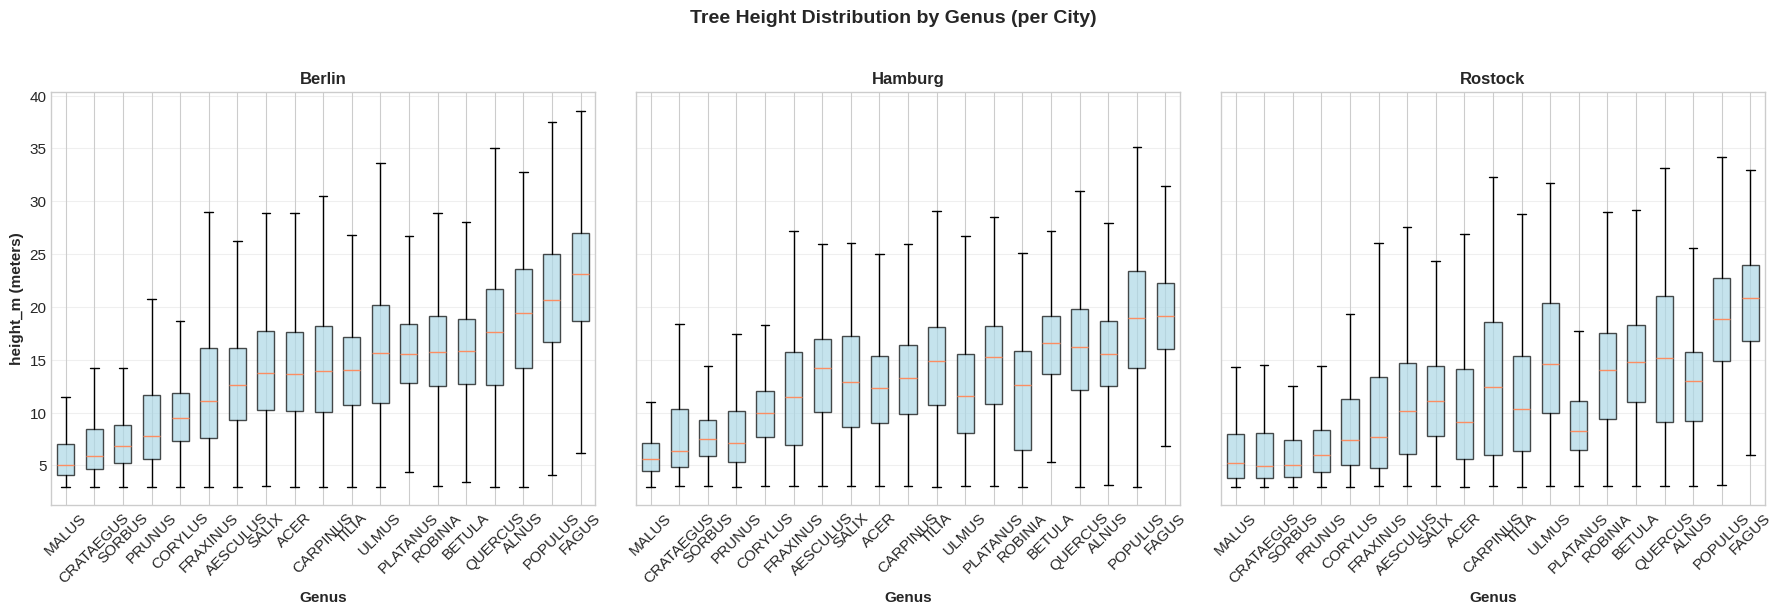

✓ Boxplot visualization saved


In [32]:
# Plot height_m distribution per genus (separately per city)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

cities = sorted(trees_no_edge['city'].unique())
genera_sorted = trees_no_edge.groupby('genus_latin')['height_m'].median().sort_values().index

for idx, city in enumerate(cities):
    ax = axes[idx]
    city_data = trees_no_edge[trees_no_edge['city'] == city]

    # Prepare data for boxplot
    plot_data = []
    plot_labels = []
    for genus in genera_sorted:
        genus_heights = city_data[city_data['genus_latin'] == genus]['height_m'].dropna()
        if len(genus_heights) >= 10:
            plot_data.append(genus_heights)
            plot_labels.append(genus)

    bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True,
                    showfliers=False, widths=0.6)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    ax.set_xlabel('Genus', fontsize=11, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('height_m (meters)', fontsize=11, fontweight='bold')
    ax.set_title(f'{city}', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Tree Height Distribution by Genus (per City)',
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'height_boxplots_per_city.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Boxplot visualization saved")

---

## 5. PHASE 2: CROSS-CITY TRANSFER RISK

### 5.1 Height Distribution Statistics (per Genus & City)

In [33]:
def calculate_height_statistics(df):
    """
    Calculate height distribution statistics per genus and city.

    Returns:
        pd.DataFrame: Stats including mean, std, median, Q25, Q75, min, max
    """
    print("\nCalculating height distribution statistics...")

    stats_list = []

    for city in df['city'].unique():
        for genus in df['genus_latin'].unique():
            subset = df[(df['city'] == city) & (df['genus_latin'] == genus)]['height_m'].dropna()

            if len(subset) < 10:
                continue

            stats_list.append({
                'city': city,
                'genus': genus,
                'n': len(subset),
                'mean': subset.mean(),
                'std': subset.std(),
                'median': subset.median(),
                'q25': subset.quantile(0.25),
                'q75': subset.quantile(0.75),
                'min': subset.min(),
                'max': subset.max()
            })

    stats_df = pd.DataFrame(stats_list)

    print(f"  ✓ Stats calculated for {len(stats_df)} (city × genus) combinations")

    return stats_df


# Calculate statistics
height_stats = calculate_height_statistics(trees_no_edge)

# Display sample
print("\nSample statistics (QUERCUS):")
print(height_stats[height_stats['genus'] == 'QUERCUS'].to_string(index=False))


Calculating height distribution statistics...
  ✓ Stats calculated for 57 (city × genus) combinations

Sample statistics (QUERCUS):
   city   genus     n      mean      std    median       q25       q75      min       max
 Berlin QUERCUS 73847 17.156431 6.010414 17.660065 12.650015 21.649532 3.000229 49.899780
Hamburg QUERCUS 25497 15.748176 5.592142 16.208998 12.165310 19.818027 3.001743 39.754723
Rostock QUERCUS  4609 15.214690 7.230371 15.190178  9.081852 21.070763 3.009050 33.097443


### 5.2 Cohen's d Calculation (Berlin/Hamburg → Rostock)

In [34]:
def calculate_cohens_d_cross_city(df, source_cities=['Berlin', 'Hamburg'], target_city='Rostock'):
    """
    Calculate Cohen's d for each genus between source and target cities.

    Returns:
        pd.DataFrame: Cohen's d values and risk classification
    """
    print(f"\nCalculating Cohen's d: {source_cities} → {target_city}")

    results = []

    for genus in df['genus_latin'].unique():
        # Target city data
        target_data = df[(df['city'] == target_city) &
                        (df['genus_latin'] == genus)]['height_m'].dropna()

        if len(target_data) < 10:
            continue

        # Calculate Cohen's d for each source city
        for source_city in source_cities:
            source_data = df[(df['city'] == source_city) &
                           (df['genus_latin'] == genus)]['height_m'].dropna()

            if len(source_data) < 10:
                continue

            # Cohen's d
            d = cohens_d(source_data.values, target_data.values)
            risk = classify_transfer_risk(d)

            results.append({
                'genus': genus,
                'source_city': source_city,
                'target_city': target_city,
                'cohens_d': d,
                'risk': risk,
                'n_source': len(source_data),
                'n_target': len(target_data)
            })

    cohens_d_df = pd.DataFrame(results)

    print(f"  ✓ Cohen's d calculated for {len(cohens_d_df)} comparisons")

    # Summary statistics
    print(f"\nRisk Distribution:")
    risk_counts = cohens_d_df['risk'].value_counts()
    for risk_level, count in risk_counts.items():
        pct = (count / len(cohens_d_df)) * 100
        print(f"  {risk_level}: {count} ({pct:.1f}%)")

    return cohens_d_df


# Calculate Cohen's d
cohens_d_results = calculate_cohens_d_cross_city(trees_no_edge)

# Show high-risk genera
high_risk = cohens_d_results[cohens_d_results['risk'] == 'high'].sort_values('cohens_d', ascending=False)
if len(high_risk) > 0:
    print(f"\nHigh-Risk Genera (d ≥ {COHENS_D_HIGH_RISK}):")
    print(high_risk[['genus', 'source_city', 'cohens_d', 'risk']].to_string(index=False))
else:
    print(f"\n✓ No high-risk genera detected (all d < {COHENS_D_HIGH_RISK})")


Calculating Cohen's d: ['Berlin', 'Hamburg'] → Rostock
  ✓ Cohen's d calculated for 38 comparisons

Risk Distribution:
  low: 27 (71.1%)
  moderate: 8 (21.1%)
  high: 3 (7.9%)

High-Risk Genera (d ≥ 0.8):
   genus source_city  cohens_d risk
PLATANUS      Berlin  1.419614 high
PLATANUS     Hamburg  0.967298 high
   ALNUS      Berlin  0.920342 high


### 5.3 Visualization: Violin Plots (Height × City × Genus)

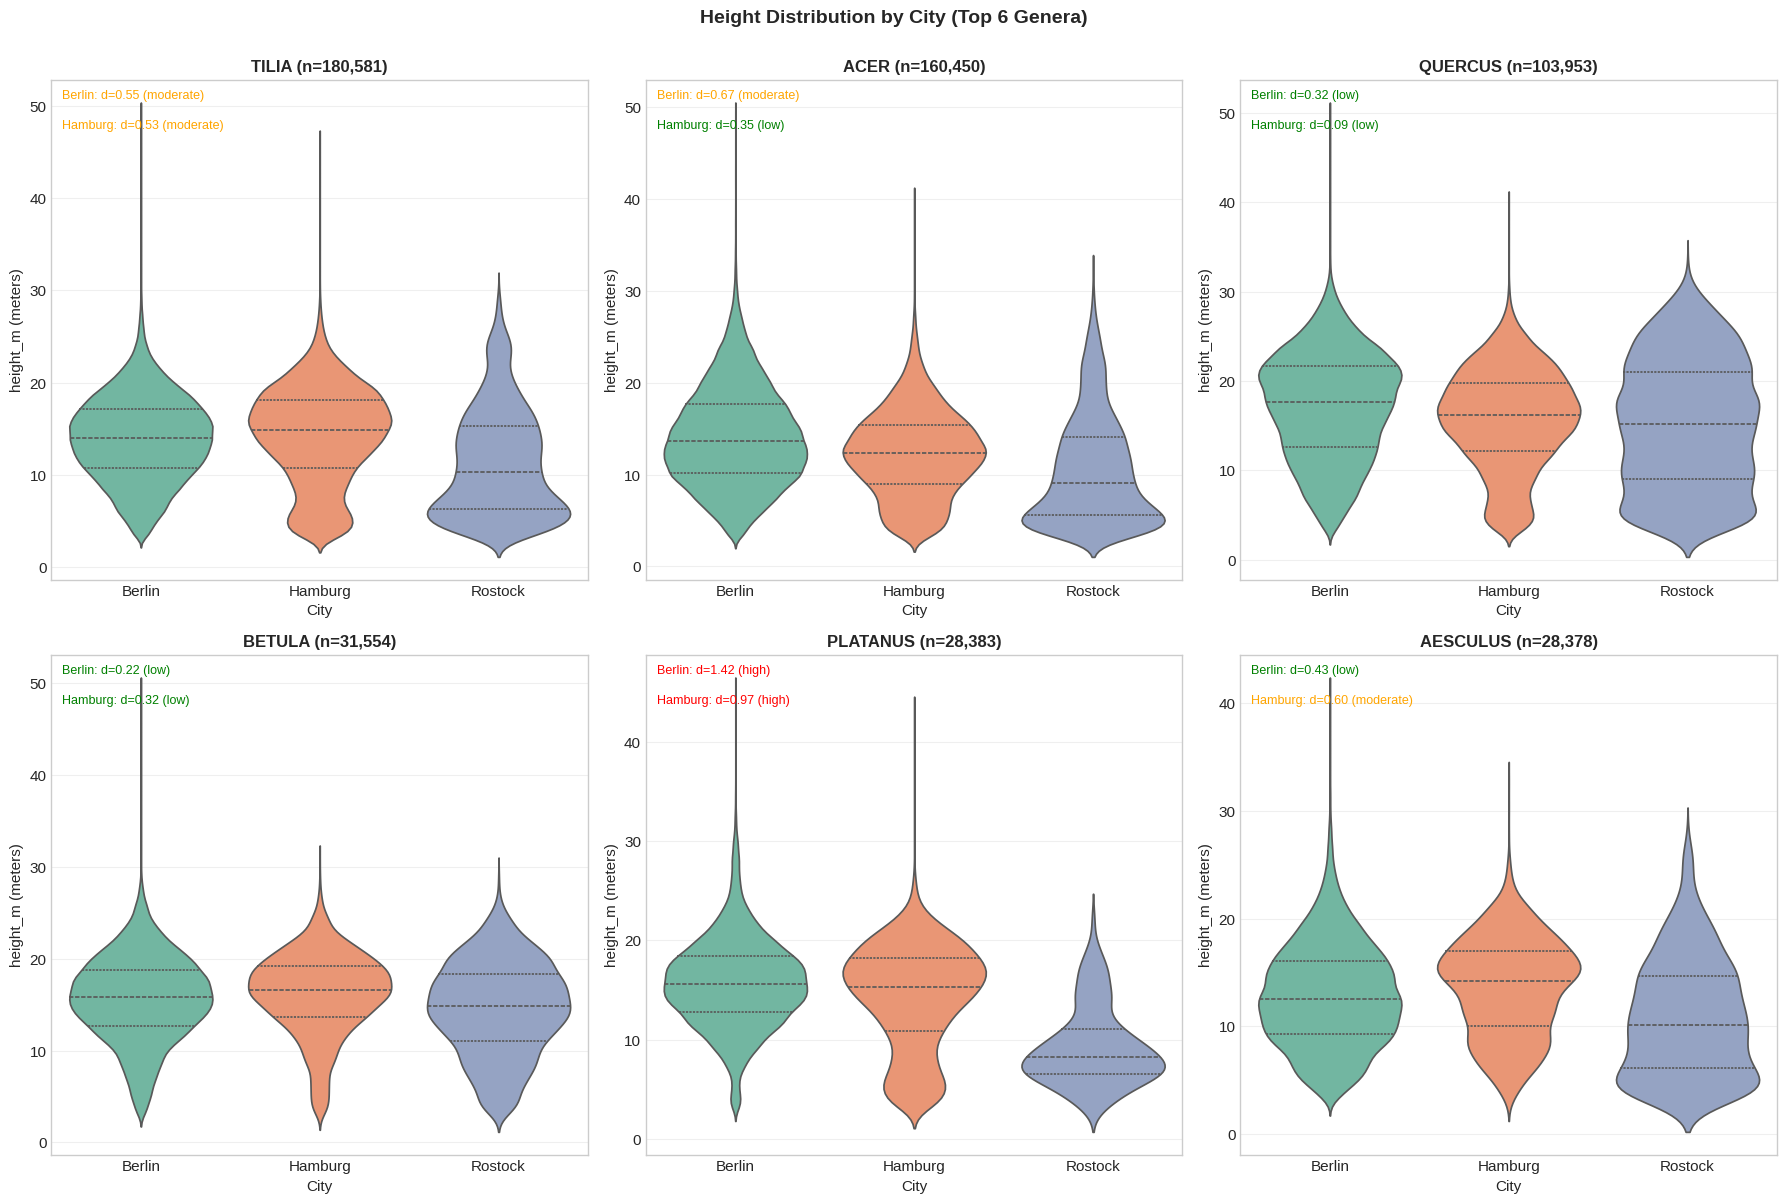

✓ Violin plot visualization saved


In [35]:
# Select top 6 genera by sample size for visualization
top_genera = trees_no_edge['genus_latin'].value_counts().head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, genus in enumerate(top_genera):
    ax = axes[idx]

    # Filter data for this genus
    genus_data = trees_no_edge[trees_no_edge['genus_latin'] == genus]

    # Violin plot
    sns.violinplot(data=genus_data, x='city', y='height_m', ax=ax,
                  palette='Set2', inner='quartile')

    ax.set_title(f'{genus} (n={len(genus_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('City', fontsize=11)
    ax.set_ylabel('height_m (meters)', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    # Add Cohen's d annotations
    for source_city in ['Berlin', 'Hamburg']:
        cd_row = cohens_d_results[
            (cohens_d_results['genus'] == genus) &
            (cohens_d_results['source_city'] == source_city)
        ]
        if len(cd_row) > 0:
            d_val = cd_row.iloc[0]['cohens_d']
            risk = cd_row.iloc[0]['risk']
            color = 'red' if risk == 'high' else 'orange' if risk == 'moderate' else 'green'
            ax.text(0.02, 0.98 - (0.06 * ['Berlin', 'Hamburg'].index(source_city)),
                   f"{source_city}: d={d_val:.2f} ({risk})",
                   transform=ax.transAxes, fontsize=9, color=color,
                   verticalalignment='top')

plt.suptitle('Height Distribution by City (Top 6 Genera)',
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'height_violin_plots_cross_city.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Violin plot visualization saved")

---

## 6. PHASE 3: FEATURE QUALITY ASSESSMENT

### 6.1 CHM Inter-Correlation (Neighbor Contamination Test)


CHM INTER-CORRELATION ANALYSIS

Correlation Matrix (No-Edge):
          height_m  CHM_mean  CHM_max  CHM_std
height_m     1.000     0.638    0.695    0.550
CHM_mean     0.638     1.000    0.820    0.581
CHM_max      0.695     0.820    1.000    0.838
CHM_std      0.550     0.581    0.838    1.000

Correlation Matrix (20m-Edge):
          height_m  CHM_mean  CHM_max  CHM_std
height_m     1.000     0.570    0.639    0.523
CHM_mean     0.570     1.000    0.790    0.594
CHM_max      0.639     0.790    1.000    0.853
CHM_std      0.523     0.594    0.853    1.000

Neighbor Contamination Diagnosis:
  r(height_m, CHM_mean) no-edge: 0.638
  r(height_m, CHM_mean) 20m-edge: 0.570
  ⚠️  CONTAMINATION DETECTED (r < 0.7)
      10m resampling likely includes neighbor trees/buildings


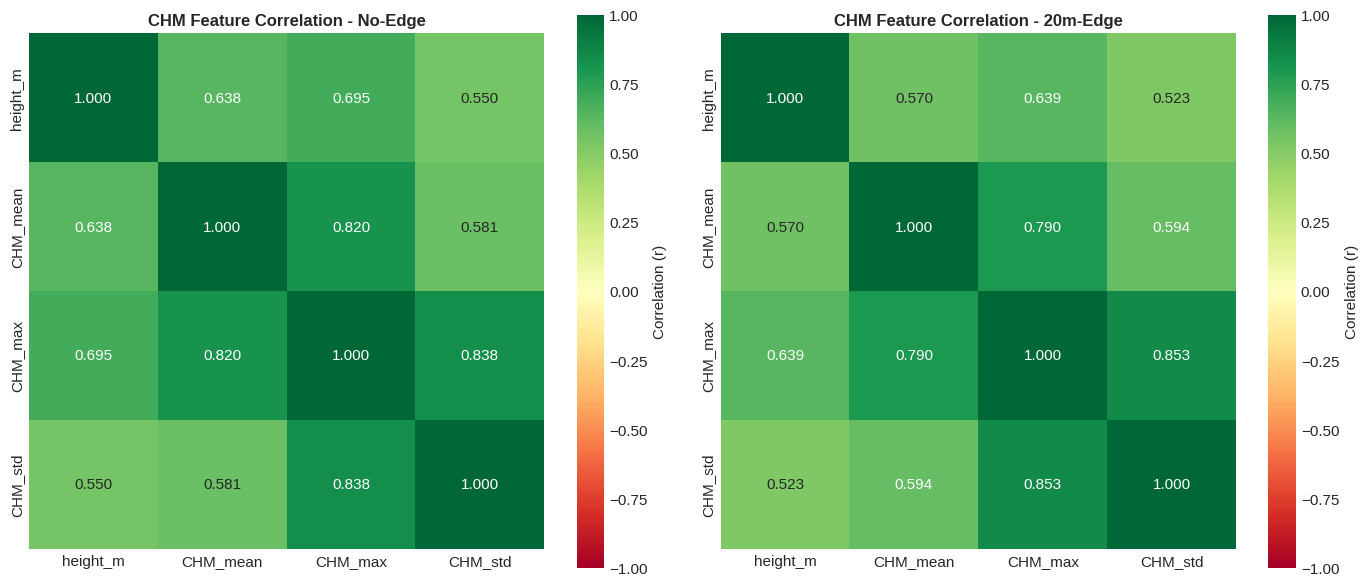


✓ Correlation heatmap saved


In [36]:
print(f"\n{'='*60}")
print("CHM INTER-CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Calculate correlation matrix
chm_corr_no = trees_no_edge[CHM_FEATURES].corr()
chm_corr_20m = trees_20m_edge[CHM_FEATURES].corr()

print("Correlation Matrix (No-Edge):")
print(chm_corr_no.round(3))

print("\nCorrelation Matrix (20m-Edge):")
print(chm_corr_20m.round(3))

# Diagnose neighbor contamination
r_height_chmmean_no = chm_corr_no.loc['height_m', 'CHM_mean']
r_height_chmmean_20m = chm_corr_20m.loc['height_m', 'CHM_mean']

print(f"\nNeighbor Contamination Diagnosis:")
print(f"  r(height_m, CHM_mean) no-edge: {r_height_chmmean_no:.3f}")
print(f"  r(height_m, CHM_mean) 20m-edge: {r_height_chmmean_20m:.3f}")

if r_height_chmmean_no < CORRELATION_CONTAMINATION:
    print(f"  ⚠️  CONTAMINATION DETECTED (r < {CORRELATION_CONTAMINATION})")
    print(f"      10m resampling likely includes neighbor trees/buildings")
    contamination_detected = True
else:
    print(f"  ✓ No contamination (r ≥ {CORRELATION_CONTAMINATION})")
    contamination_detected = False

# Visualize correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (corr_matrix, title) in enumerate([(chm_corr_no, 'No-Edge'),
                                             (chm_corr_20m, '20m-Edge')]):
    ax = axes[idx]
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=-1, vmax=1, center=0, square=True, ax=ax,
               cbar_kws={'label': 'Correlation (r)'})
    ax.set_title(f'CHM Feature Correlation - {title}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'chm_correlation_heatmap.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Correlation heatmap saved")

### 6.2 CHM-Spectral Correlation (Redundancy Check)

In [37]:
# Identify spectral features (bands + indices)
spectral_features = [col for col in trees_no_edge.columns
                    if any(col.startswith(prefix) for prefix in
                          ['B0', 'B1', 'NDVI', 'EVI', 'NDRE', 'CIre', 'IRECI'])]

# Select a subset for correlation analysis (avoid memory issues)
sample_spectral = spectral_features[:20]  # First 20 spectral features

print(f"\nCHM-Spectral Correlation (sample: {len(sample_spectral)} features)")

# Calculate correlations
corr_chm_spectral = trees_no_edge[CHM_FEATURES + sample_spectral].corr()
chm_spectral_cross = corr_chm_spectral.loc[CHM_FEATURES, sample_spectral]

# Find highest correlations
max_corr_per_chm = chm_spectral_cross.abs().max(axis=1)

print("\nMax |r| between CHM and Spectral Features:")
for chm_feat, max_r in max_corr_per_chm.items():
    # Find which spectral feature
    max_spectral = chm_spectral_cross.loc[chm_feat].abs().idxmax()
    actual_r = chm_spectral_cross.loc[chm_feat, max_spectral]
    print(f"  {chm_feat} ↔ {max_spectral}: r = {actual_r:.3f}")

    if abs(actual_r) > CORRELATION_REDUNDANCY:
        print(f"    ⚠️  HIGH REDUNDANCY (|r| > {CORRELATION_REDUNDANCY})")

# Check if any CHM feature is redundant
redundant_chm = max_corr_per_chm[max_corr_per_chm > CORRELATION_REDUNDANCY]
if len(redundant_chm) > 0:
    print(f"\n⚠️  Redundant CHM features detected: {redundant_chm.index.tolist()}")
else:
    print(f"\n✓ No redundancy detected (all |r| < {CORRELATION_REDUNDANCY})")


CHM-Spectral Correlation (sample: 20 features)

Max |r| between CHM and Spectral Features:
  height_m ↔ NDVI_06: r = 0.550
  CHM_mean ↔ B12_06: r = -0.447
  CHM_max ↔ B12_09: r = -0.454
  CHM_std ↔ B12_09: r = -0.346

✓ No redundancy detected (all |r| < 0.95)


### 6.3 Edge-Filter Impact on η²

In [38]:
print(f"\n{'='*60}")
print("EDGE-FILTER IMPACT ANALYSIS")
print(f"{'='*60}\n")

# Compare η² between no-edge and 20m-edge
eta2_comparison = anova_results_combined.pivot(index='feature',
                                               columns='dataset',
                                               values='eta2')

# Calculate η² change
eta2_comparison['eta2_change'] = (eta2_comparison['20m_edge'] -
                                 eta2_comparison['no_edge'])
eta2_comparison['eta2_change_pct'] = (eta2_comparison['eta2_change'] /
                                     eta2_comparison['no_edge'] * 100)

print("η² Comparison (No-Edge vs. 20m-Edge):")
print(eta2_comparison.round(3))

# Interpret
print("\nInterpretation:")
for feature in CHM_FEATURES:
    if feature not in eta2_comparison.index:
        continue

    change_pct = eta2_comparison.loc[feature, 'eta2_change_pct']

    if change_pct < -10:
        print(f"  {feature}: η² DECREASED {abs(change_pct):.1f}% with edge filter")
        print(f"    → Suggests neighborhood-dependency (edge trees less discriminative)")
    elif change_pct > 10:
        print(f"  {feature}: η² INCREASED {change_pct:.1f}% with edge filter")
        print(f"    → Edge filtering improved signal quality")
    else:
        print(f"  {feature}: η² stable ({change_pct:+.1f}%)")


EDGE-FILTER IMPACT ANALYSIS

η² Comparison (No-Edge vs. 20m-Edge):
dataset   20m_edge  no_edge  eta2_change  eta2_change_pct
feature                                                  
CHM_max      0.073    0.075       -0.002           -2.651
CHM_mean     0.062    0.082       -0.019          -23.659
CHM_std      0.046    0.037        0.008           22.542
height_m     0.192    0.174        0.018           10.135

Interpretation:
  height_m: η² INCREASED 10.1% with edge filter
    → Edge filtering improved signal quality
  CHM_mean: η² DECREASED 23.7% with edge filter
    → Suggests neighborhood-dependency (edge trees less discriminative)
  CHM_max: η² stable (-2.7%)
  CHM_std: η² INCREASED 22.5% with edge filter
    → Edge filtering improved signal quality


---

## 7. PHASE 4: CITY-INVARIANT FEATURE ENGINEERING

### 7.1 Z-Score Normalization (per City & Genus)

In [39]:
def add_zscore_normalization(df, feature='height_m', min_samples=MIN_GENUS_SAMPLES_NORM):
    """
    Add Z-score normalized height feature (genus & city specific).
    Fallback to city-level if genus too small.
    """
    df = df.copy()
    norm_col = f"{feature}_norm"
    df[norm_col] = np.nan

    for city in df['city'].unique():
        for genus in df['genus_latin'].unique():
            mask = (df['city'] == city) & (df['genus_latin'] == genus)
            subset = df.loc[mask, feature]

            if len(subset) >= min_samples:
                # Genus-level normalization
                mean_val = subset.mean()
                std_val = subset.std()
                if std_val > 0:
                    df.loc[mask, norm_col] = (subset - mean_val) / std_val
            else:
                # Fallback: City-level normalization
                city_mask = df['city'] == city
                city_mean = df.loc[city_mask, feature].mean()
                city_std = df.loc[city_mask, feature].std()
                if city_std > 0:
                    df.loc[mask, norm_col] = (subset - city_mean) / city_std

    return df


print("Adding Z-score normalization...\n")

# Apply to both datasets
trees_no_edge_eng = add_zscore_normalization(trees_no_edge, 'height_m')
trees_20m_edge_eng = add_zscore_normalization(trees_20m_edge, 'height_m')

print("✓ height_m_norm added")

# Validate
print(f"\nValidation (No-Edge):")
print(f"  Non-NaN values: {trees_no_edge_eng['height_m_norm'].notna().sum():,}")
print(f"  Mean: {trees_no_edge_eng['height_m_norm'].mean():.3f} (should be ≈0)")
print(f"  Std: {trees_no_edge_eng['height_m_norm'].std():.3f} (should be ≈1)")

Adding Z-score normalization...

✓ height_m_norm added

Validation (No-Edge):
  Non-NaN values: 714,676
  Mean: -0.000 (should be ≈0)
  Std: 1.000 (should be ≈1)


### 7.2 Percentile Rank (per City & Genus)

In [40]:
def add_percentile_rank(df, feature='height_m'):
    """
    Add percentile rank feature (genus & city specific).
    Range: 0-1 (0 = shortest, 1 = tallest within city/genus group).
    """
    df = df.copy()
    percentile_col = f"{feature}_percentile"

    df[percentile_col] = df.groupby(['city', 'genus_latin'])[feature].rank(pct=True)

    return df


print("\nAdding percentile rank...\n")

# Apply to both datasets
trees_no_edge_eng = add_percentile_rank(trees_no_edge_eng, 'height_m')
trees_20m_edge_eng = add_percentile_rank(trees_20m_edge_eng, 'height_m')

print("✓ height_m_percentile added")

# Validate
print(f"\nValidation (No-Edge):")
print(f"  Range: [{trees_no_edge_eng['height_m_percentile'].min():.3f}, "
     f"{trees_no_edge_eng['height_m_percentile'].max():.3f}] (should be [0, 1])")
print(f"  Mean: {trees_no_edge_eng['height_m_percentile'].mean():.3f} (should be ≈0.5)")


Adding percentile rank...

✓ height_m_percentile added

Validation (No-Edge):
  Range: [0.000, 1.000] (should be [0, 1])
  Mean: 0.500 (should be ≈0.5)


### 7.3 Optional: Ratio Features (if correlation sufficient)

In [41]:
# Only create ratio if r(height_m, CHM_mean) ≥ 0.5
if r_height_chmmean_no >= 0.5:
    print(f"\nCreating ratio features (r = {r_height_chmmean_no:.3f} ≥ 0.5)...\n")

    # Crown ratio (CHM_mean / height_m)
    trees_no_edge_eng['crown_ratio'] = (
        trees_no_edge_eng['CHM_mean'] / trees_no_edge_eng['height_m']
    ).replace([np.inf, -np.inf], np.nan)

    trees_20m_edge_eng['crown_ratio'] = (
        trees_20m_edge_eng['CHM_mean'] / trees_20m_edge_eng['height_m']
    ).replace([np.inf, -np.inf], np.nan)

    print("✓ crown_ratio added")

    # Validate
    valid_ratios = trees_no_edge_eng['crown_ratio'].dropna()
    print(f"\nValidation (No-Edge):")
    print(f"  Valid ratios: {len(valid_ratios):,}")
    print(f"  Range: [{valid_ratios.min():.3f}, {valid_ratios.max():.3f}]")
    print(f"  Mean: {valid_ratios.mean():.3f}")

    ratio_created = True
else:
    print(f"\n⚠️  Ratio features NOT created (r = {r_height_chmmean_no:.3f} < 0.5)")
    print("     Low correlation indicates contamination → ratio would be noise")
    ratio_created = False


Creating ratio features (r = 0.638 ≥ 0.5)...

✓ crown_ratio added

Validation (No-Edge):
  Valid ratios: 714,632
  Range: [0.000, 9.208]
  Mean: 0.444


---

## 8. PHASE 5: DECISION LOGIC & EXPORT

### 8.1 Automated Feature Classification

In [42]:
print(f"\n{'='*60}")
print("FEATURE DECISION LOGIC")
print(f"{'='*60}\n")

feature_decisions = {}
rationale = {}

# Assess height_m
height_eta2 = anova_results_no[anova_results_no['feature'] == 'height_m']['eta2'].values[0]
high_risk_genera = cohens_d_results[cohens_d_results['risk'] == 'high']['genus'].unique()
high_risk_pct = (len(high_risk_genera) / cohens_d_results['genus'].nunique()) * 100

if height_eta2 >= ETA2_STRONG_THRESHOLD:
    if high_risk_pct < 50:
        decision_height = 'KEEP'
        rationale_height = f"Strong discriminator (η²={height_eta2:.3f}), moderate transfer risk ({high_risk_pct:.0f}% high-risk genera). Keep for ablation study."
    else:
        decision_height = 'KEEP_ABLATION'
        rationale_height = f"Strong discriminator (η²={height_eta2:.3f}) BUT high transfer risk ({high_risk_pct:.0f}% high-risk genera). Keep ONLY for ablation study to quantify overfitting."
else:
    decision_height = 'EXCLUDE'
    rationale_height = f"Weak discriminator (η²={height_eta2:.3f} < {ETA2_STRONG_THRESHOLD}). Not worth transfer risk."

feature_decisions['height_m'] = decision_height
rationale['height_m'] = rationale_height

# Assess CHM_resampled features
if contamination_detected:
    for feat in ['CHM_mean', 'CHM_max', 'CHM_std']:
        feature_decisions[feat] = 'EXCLUDE'
        rationale[feat] = f"Neighbor contamination detected (r(height_m, CHM_mean)={r_height_chmmean_no:.3f} < {CORRELATION_CONTAMINATION}). 10m resampling unsuitable for urban trees."
else:
    # If no contamination, decide based on η²
    for feat in ['CHM_mean', 'CHM_max', 'CHM_std']:
        feat_eta2 = anova_results_no[anova_results_no['feature'] == feat]['eta2'].values[0]

        if feat_eta2 >= ETA2_STRONG_THRESHOLD:
            feature_decisions[feat] = 'KEEP'
            rationale[feat] = f"No contamination detected, strong discriminator (η²={feat_eta2:.3f})."
        else:
            feature_decisions[feat] = 'EXCLUDE'
            rationale[feat] = f"Weak discriminator (η²={feat_eta2:.3f} < {ETA2_STRONG_THRESHOLD})."

# Engineered features (always KEEP for ablation)
feature_decisions['height_m_norm'] = 'KEEP'
rationale['height_m_norm'] = "City-invariant normalization (Z-score per city/genus). For ablation study."

feature_decisions['height_m_percentile'] = 'KEEP'
rationale['height_m_percentile'] = "Robust city-invariant feature (percentile rank). For ablation study."

if ratio_created:
    feature_decisions['crown_ratio'] = 'KEEP'
    rationale['crown_ratio'] = f"City-invariant ratio feature (r={r_height_chmmean_no:.3f} ≥ 0.5). Potential structural information."

# Print decisions
print("Feature Decisions:\n")
for feature, decision in feature_decisions.items():
    print(f"  {feature}: {decision}")
    print(f"    → {rationale[feature]}")
    print()


FEATURE DECISION LOGIC

Feature Decisions:

  height_m: KEEP
    → Strong discriminator (η²=0.174), moderate transfer risk (11% high-risk genera). Keep for ablation study.

  CHM_mean: EXCLUDE
    → Neighbor contamination detected (r(height_m, CHM_mean)=0.638 < 0.7). 10m resampling unsuitable for urban trees.

  CHM_max: EXCLUDE
    → Neighbor contamination detected (r(height_m, CHM_mean)=0.638 < 0.7). 10m resampling unsuitable for urban trees.

  CHM_std: EXCLUDE
    → Neighbor contamination detected (r(height_m, CHM_mean)=0.638 < 0.7). 10m resampling unsuitable for urban trees.

  height_m_norm: KEEP
    → City-invariant normalization (Z-score per city/genus). For ablation study.

  height_m_percentile: KEEP
    → Robust city-invariant feature (percentile rank). For ablation study.

  crown_ratio: KEEP
    → City-invariant ratio feature (r=0.638 ≥ 0.5). Potential structural information.



### 8.2 Filter & Export Final Datasets (KEEP features only)

In [43]:
print(f"\n{'='*60}")
print("EXPORT: Final datasets with selected CHM features only")
print(f"{'='*60}\n")

# Identify KEEP features (including engineered)
keep_chm_features = [f for f, decision in feature_decisions.items()
                     if decision in ['KEEP', 'KEEP_ABLATION']]

print(f"CHM Features to KEEP: {keep_chm_features}")

# Identify all column categories
# 1. Metadata columns
metadata_cols = ['tree_id', 'genus_latin', 'city', 'species_group', 'tree_type']
if 'geometry' in trees_no_edge_eng.columns:
    metadata_cols.append('geometry')

# Only keep metadata that exists in dataset
metadata_cols = [col for col in metadata_cols if col in trees_no_edge_eng.columns]

# 2. Spectral/temporal features
# CORRECTED: Use prefixes matching current data (single digit bands B2-B8 have no leading zero yet)
# We will rename them to B02-B08 before export
spectral_prefixes = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
                    'NDVI', 'EVI', 'GNDVI', 'SAVI', 'MSAVI', 'NDRE', 'CIre', 'MCARI',
                    'NDWI', 'MSI', 'NDII', 'kNDVI', 'NDVIre', 'NDre1', 'IRECI', 'RTVIcore', 'VARI']

spectral_cols = [col for col in trees_no_edge_eng.columns
                if any(col.startswith(prefix) for prefix in spectral_prefixes)]

# 3. CHM features (only KEEP ones)
keep_chm_cols = [col for col in keep_chm_features if col in trees_no_edge_eng.columns]

# Combine all
final_cols = metadata_cols + spectral_cols + keep_chm_cols

print(f"\nFinal Dataset Structure:")
print(f"  Metadata: {len(metadata_cols)} columns")
print(f"  Spectral: {len(spectral_cols)} columns")
print(f"  CHM (KEEP): {len(keep_chm_cols)} columns")
print(f"  TOTAL: {len(final_cols)} columns")

# Filter datasets to final columns only
trees_no_edge_final = trees_no_edge_eng[final_cols].copy()
trees_20m_edge_final = trees_20m_edge_eng[final_cols].copy()

# --- RENAMING LOGIC ---
def rename_bands_with_leading_zero(df):
    """Renames B2_xx to B02_xx, etc."""
    rename_map = {}
    for col in df.columns:
        # Check for B + digit + _ (e.g., B2_03)
        if col.startswith('B') and col[1].isdigit() and col[2] == '_':
            new_name = f"B0{col[1:]}"
            rename_map[col] = new_name

    if rename_map:
        print(f"  Renaming {len(rename_map)} columns (adding leading zeros to B2-B8)...")
        df = df.rename(columns=rename_map)
    return df

print("\nStandardizing band names (adding leading zeros)...")
trees_no_edge_final = rename_bands_with_leading_zero(trees_no_edge_final)
trees_20m_edge_final = rename_bands_with_leading_zero(trees_20m_edge_final)
# ----------------------

# Export no-edge
output_no_edge = OUTPUT_DATA_DIR / 'trees_clean_chm_final_no_edge.gpkg'
trees_no_edge_final.to_file(output_no_edge, driver='GPKG')
print(f"\n✓ Exported: {output_no_edge.name}")
print(f"  Trees: {len(trees_no_edge_final):,}")
print(f"  Columns: {len(trees_no_edge_final.columns)}")
print(f"  CHM features: {keep_chm_cols}")

# Export 20m-edge
output_20m_edge = OUTPUT_DATA_DIR / 'trees_clean_chm_final_20m_edge.gpkg'
trees_20m_edge_final.to_file(output_20m_edge, driver='GPKG')
print(f"\n✓ Exported: {output_20m_edge.name}")
print(f"  Trees: {len(trees_20m_edge_final):,}")
print(f"  Columns: {len(trees_20m_edge_final.columns)}")
print(f"  CHM features: {keep_chm_cols}")

# Show what was removed
excluded_chm = [f for f, decision in feature_decisions.items()
               if decision == 'EXCLUDE' and f in CHM_FEATURES]
if excluded_chm:
    print(f"\n⚠️  Removed CHM features: {excluded_chm}")
    print(f"     Reason: See chm_feature_decisions.json for rationale")
else:
    print(f"\n✓ All original CHM features kept (no exclusions)")

# Memory cleanup
del trees_no_edge_eng, trees_20m_edge_eng
gc.collect()
print(f"\n✓ Memory cleaned")


EXPORT: Final datasets with selected CHM features only

CHM Features to KEEP: ['height_m', 'height_m_norm', 'height_m_percentile', 'crown_ratio']

Final Dataset Structure:
  Metadata: 5 columns
  Spectral: 184 columns
  CHM (KEEP): 4 columns
  TOTAL: 193 columns

Standardizing band names (adding leading zeros)...
  Renaming 56 columns (adding leading zeros to B2-B8)...
  Renaming 56 columns (adding leading zeros to B2-B8)...

✓ Exported: trees_clean_chm_final_no_edge.gpkg
  Trees: 714,676
  Columns: 193
  CHM features: ['height_m', 'height_m_norm', 'height_m_percentile', 'crown_ratio']

✓ Exported: trees_clean_chm_final_20m_edge.gpkg
  Trees: 289,525
  Columns: 193
  CHM features: ['height_m', 'height_m_norm', 'height_m_percentile', 'crown_ratio']

⚠️  Removed CHM features: ['CHM_mean', 'CHM_max', 'CHM_std']
     Reason: See chm_feature_decisions.json for rationale

✓ Memory cleaned


### 8.3 Export Metadata & Reports

In [44]:
print(f"\nExporting metadata...\n")

# 1. ANOVA Results CSV
anova_path = OUTPUT_METADATA_DIR / 'chm_relevance_analysis.csv'
anova_results_combined.to_csv(anova_path, index=False)
print(f"✓ Exported: {anova_path.name}")

# 2. Cross-City Height Stats JSON
height_stats_export = {
    'height_statistics': height_stats.to_dict('records'),
    'cohens_d_analysis': cohens_d_results.to_dict('records'),
    'summary': {
        'high_risk_genera': high_risk_genera.tolist() if len(high_risk_genera) > 0 else [],
        'high_risk_percentage': round(high_risk_pct, 1)
    }
}
height_stats_path = OUTPUT_METADATA_DIR / 'cross_city_height_analysis.json'
with open(height_stats_path, 'w') as f:
    json.dump(height_stats_export, f, indent=2)
print(f"✓ Exported: {height_stats_path.name}")

# 3. Correlation Analysis JSON
correlation_export = {
    'chm_inter_correlation': {
        'no_edge': chm_corr_no.to_dict(),
        '20m_edge': chm_corr_20m.to_dict()
    },
    'neighbor_contamination': {
        'r_height_chmmean_no_edge': round(r_height_chmmean_no, 3),
        'r_height_chmmean_20m_edge': round(r_height_chmmean_20m, 3),
        'contamination_detected': contamination_detected,
        'threshold': CORRELATION_CONTAMINATION
    },
    'edge_filter_impact': eta2_comparison.to_dict()
}
corr_path = OUTPUT_METADATA_DIR / 'chm_correlation_analysis.json'
with open(corr_path, 'w') as f:
    json.dump(correlation_export, f, indent=2)
print(f"✓ Exported: {corr_path.name}")

# 4. Feature Decisions JSON
decisions_export = {
    'processing_date': datetime.now().isoformat(),
    'decisions': feature_decisions,
    'rationale': rationale,
    'thresholds': {
        'eta2_strong': ETA2_STRONG_THRESHOLD,
        'cohens_d_high_risk': COHENS_D_HIGH_RISK,
        'correlation_contamination': CORRELATION_CONTAMINATION,
        'correlation_redundancy': CORRELATION_REDUNDANCY
    }
}
decisions_path = OUTPUT_METADATA_DIR / 'chm_feature_decisions.json'
with open(decisions_path, 'w') as f:
    json.dump(decisions_export, f, indent=2)
print(f"✓ Exported: {decisions_path.name}")

# 5. Comprehensive Markdown Report
report_md = f"""# CHM Relevance Assessment Report

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Notebook:** 03c_chm_relevance_assessment.ipynb

---

## Executive Summary

### Feature Decisions

{''.join([f"- **{feat}:** {dec} - {rationale[feat]}\n" for feat, dec in feature_decisions.items()])}

---

## 1. Within-City Discriminative Power (η²)

{''.join([f"- **{row['feature']}:** η² = {row['eta2']:.3f} ({row['classification']})\n" for _, row in anova_results_no.iterrows()])}

**Interpretation:** Features with η² ≥ {ETA2_STRONG_THRESHOLD} are considered strong discriminators.

---

## 2. Cross-City Transfer Risk (Cohen's d)

**High-Risk Genera (d ≥ {COHENS_D_HIGH_RISK}):** {', '.join(high_risk_genera) if len(high_risk_genera) > 0 else 'None'}

**Risk Distribution:**
- High risk: {high_risk_pct:.0f}% of genera
- Moderate/Low risk: {100-high_risk_pct:.0f}% of genera

**Conclusion:** {'Height features show HIGH transfer risk - models may learn city-specific patterns.' if high_risk_pct >= 50 else 'Transfer risk is MODERATE - height features can be used with caution.'}

---

## 3. Feature Quality Assessment

### Neighbor Contamination
- r(height_m, CHM_mean) = {r_height_chmmean_no:.3f}
- **Diagnosis:** {'CONTAMINATION DETECTED' if contamination_detected else 'No contamination'}
- **Conclusion:** {'10m CHM resampling likely includes neighbor trees/buildings. CHM_resampled features EXCLUDED.' if contamination_detected else 'CHM_resampled features appear reliable.'}

### Edge-Filter Impact
{''.join([f"- **{feat}:** η² changed {eta2_comparison.loc[feat, 'eta2_change_pct']:+.1f}%\n" for feat in CHM_FEATURES if feat in eta2_comparison.index])}

---

## 4. Engineered Features

**Created:**
- `height_m_norm`: Z-score normalization (per city & genus)
- `height_m_percentile`: Percentile rank (per city & genus)
{f"- `crown_ratio`: CHM_mean / height_m (structural indicator)" if ratio_created else ''}

**Purpose:** City-invariant alternatives for ablation studies.

---

## 5. Next Steps

1. **Correlation Analysis (Notebook 03d):** Use feature decisions to filter KEEP-features only
2. **Ablation Study Design:** Test S2_only vs. S2+height_m vs. S2+height_m_norm
3. **Cross-City Experiments:** Quantify actual transfer performance with/without CHM
"""

report_path = OUTPUT_METADATA_DIR / 'chm_assessment_report.md'
with open(report_path, 'w') as f:
    f.write(report_md)
print(f"✓ Exported: {report_path.name}")

print(f"\n{'='*60}")
print("CHM RELEVANCE ASSESSMENT COMPLETE")
print(f"{'='*60}")
print(f"\nOutputs saved to: {OUTPUT_DATA_DIR}")
print(f"  Data: 2 GeoPackages (trees_clean_chm_final_*.gpkg)")
print(f"    → Only KEEP features included, EXCLUDE features removed")
print(f"  Metadata: 4 files (CSV, JSON×3, Markdown)")
print(f"  Figures: 3 visualizations")
print(f"\n✓ Ready for next step: Correlation Analysis (Notebook 03d)")


Exporting metadata...

✓ Exported: chm_relevance_analysis.csv
✓ Exported: cross_city_height_analysis.json
✓ Exported: chm_correlation_analysis.json
✓ Exported: chm_feature_decisions.json
✓ Exported: chm_assessment_report.md

CHM RELEVANCE ASSESSMENT COMPLETE

Outputs saved to: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/03_chm_assessment/data
  Data: 2 GeoPackages (trees_clean_chm_final_*.gpkg)
    → Only KEEP features included, EXCLUDE features removed
  Metadata: 4 files (CSV, JSON×3, Markdown)
  Figures: 3 visualizations

✓ Ready for next step: Correlation Analysis (Notebook 03d)


---

**Notebook End**

**Next Notebook:** `03d_correlation_analysis.ipynb`  
**Input for Next Step:** `trees_clean_chm_final_*.gpkg` (nur KEEP-Features)

**Key Outputs:**
- 2 GeoPackages mit finalen CHM-Features (EXCLUDE-Features wurden entfernt)
- `chm_feature_decisions.json` dokumentiert alle Entscheidungen + Rationale
- Nächstes Notebook verwendet nur noch die KEEP-Features für Korrelationsanalyse

**Author:** Silas Pignotti  
**Date:** Januar 2026